In [104]:
import torch
from torchvision import models, transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.inception_v3(pretrained=True)
model = model.to(device).eval()

/Users/patrickhultquist/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/patrickhultquist/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [144]:
import json

with open('./labels.json') as f:
    imagenet_labels = json.load(f)

In [146]:
from torchvision import models, transforms

preprocess = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.CenterCrop(299)
])

tabby = Image.open("./cat.jpg")
tabby = transform(tabby)
# tabby = tabby.unsqueeze(0)  # add batch dimension
tabby = tabby.to(device)

tabby.shape

torch.Size([3, 299, 299])

In [150]:
import matplotlib.pyplot as plt

def idx2label(idx):
    return imagenet_labels[idx]

def label2idx(label):
    return imagenet_labels.index(label)

def classify(img_tensor):
    with torch.no_grad():
        output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    return predicted

def classify_from_file(filename: str):
    img_file = Image.open(filename)
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.CenterCrop(299)
    ])

    img_file = preprocess(img)

    return idx2label(classify(img_tensor))

def classify_topk(img_tensor, k=5):
    with torch.no_grad():
        output = model(img_tensor)
    _, predicted = torch.topk(output, k=k, dim=1)
    return predicted

def display_tensor(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.show()

classify_from_file('./cat.jpg')

'tabby, tabby cat'

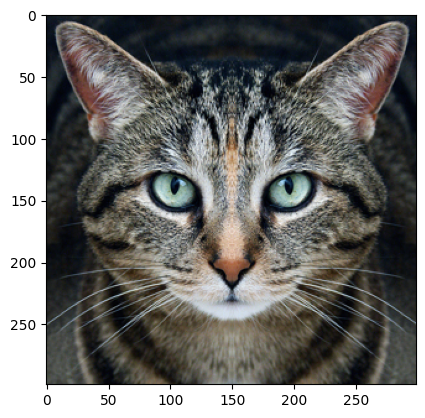

In [98]:
import numpy as np

img = Image.open('./cat.jpg')

big_dim = max(img.width, img.height)
wide = img.width > img.height

# Resize image and crop
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))

# Convert image to numpy array and normalize pixel values
img = (np.asarray(img) / 255.0).astype(np.float32)

# Convert numpy array to tensor
img_tensor = torch.from_numpy(img).permute(2, 0, 1)  # Channels first

# Add batch dimension
img_tensor = img_tensor.unsqueeze(0)  # Add batch dimension

classify(img_tensor)
display_tensor(img_tensor.squeeze())

In [100]:
import torch.nn as nn
import torch.optim as optim

x_hat = img_tensor.clone().detach().requires_grad_(True)
y_hat = torch.tensor([281], dtype=torch.long, device=device)  # replace 281 with your target class

learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD([x_hat], lr=learning_rate)

In [128]:
# Define the bounds
below = img_tensor - epsilon
above = img_tensor + epsilon


In [159]:
demo_epsilon = 10.0 / 255.0  # a really small perturbation
demo_lr = 1e-1
demo_steps = 100
demo_target = label2idx("sombrero") 

y_hat = torch.tensor([demo_target], dtype=torch.long, device=device)

optimizer = optim.SGD([x_hat], lr=demo_lr)

x_hat.data = img_tensor.clone()

below = img_tensor - demo_epsilon
above = img_tensor + demo_epsilon

for i in range(demo_steps):
    # Forward
    output = model(x_hat)

    loss = loss_fn(output, y_hat)

    loss.backward()
    optimizer.step()

    optimizer.zero_grad()

    with torch.no_grad():
        x_hat.data.clamp_(below, above).clamp_(0, 1)

    if (i + 1) % 10 == 0:
        print('step %d, loss=%g' % (i + 1, loss.item()))

# Retrieve the adversarial example
adv = x_hat.clone().detach()

step 10, loss=0.964626
step 20, loss=0.279246
step 30, loss=0.14696
step 40, loss=0.095257
step 50, loss=0.068379
step 60, loss=0.0528274
step 70, loss=0.0429257
step 80, loss=0.036139
step 90, loss=0.0311106
step 100, loss=0.0273199


In [160]:
[idx2label(x) for x in classify_topk(adv).squeeze()]

['sombrero',
 'cowboy hat, ten-gallon hat',
 'Egyptian cat',
 'tabby, tabby cat',
 'lynx, catamount']

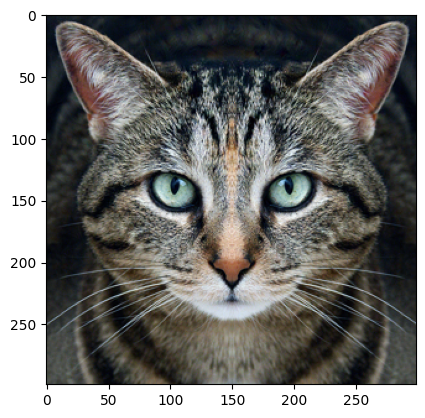

In [161]:
display_tensor(adv.squeeze())

In [164]:
plt.imsave('source.png', img_tensor.squeeze().numpy().transpose((1, 2, 0)))
plt.imsave('adversarial.png', adv.squeeze().numpy().transpose((1, 2, 0)))